<H3>Global Model-Agnostic Methods</H3>
<p>Global methods describe the average behaviour of a machine learning model. They are often expressed as expected values based on distribution of data</p>
<ul>
    <li>PDP, partial dependence plot is a feature effect method</li>
    <li>the method can be used in both classification and regression problems</li>
    <li><b>PDP assumption</b> is that target feature S is not correlated to any other features in feature space</li>
</ul>

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lib.process_data import process_bike

In [47]:
# set up plotting theme and configurations
#plt.style.available # to find all the style available to matplotlib
plt.style.use('ggplot')
colour_collection = {'orange':"#ff9124", 'blue':"#2492ff"}

In [3]:
# loading bike data
cols_df, bike_df = process_bike("./data/bike.csv")
feature_cols = cols_df.loc[cols_df.input.isin(['num']),'cols'].to_list()
resp = 'cnt'
X = bike_df[feature_cols].to_numpy()
y = bike_df[resp].to_numpy()

convert yr to string


In [4]:
# loading bike model and fetching predicted value along with bike_df
bike_model = loaded_model = pickle.load(open("./model/bike_lasso.sav",'rb'))
y_pred = bike_model.predict(X)
outcome_df = pd.DataFrame(data=np.hstack([X
    , y.reshape(-1,1)
    , bike_model.predict(X).reshape(-1,1)
]), columns = feature_cols + ['actual','predicted'])
outcome_df.head(5)

,temp,hum,windspeed,days_since_2011,season_encoded,yr_encoded,mnth_encoded,holiday_encoded,weekday_encoded,workingday_encoded,weathersit_encoded,actual,predicted
0,8.175849,80.5833,10.749882,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,985.0,1302.340894
1,9.083466,69.6087,16.652113,1.0,3.0,0.0,0.0,0.0,6.0,0.0,0.0,801.0,1346.367326
2,1.229108,43.7273,16.636703,2.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1349.0,1203.845992
3,1.400000,59.0435,10.739832,3.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1562.0,1172.281448
4,2.666979,43.6957,12.522300,4.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1600.0,1607.003516


In [5]:
# loading the encode map
encode_map = {'season':['SPRING','SUMMER','FALL','WINTER']
        , 'yr':['2011','2012']
        , 'mnth':['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
        , 'holiday':['NO HOLIDAY','HOLIDAY']
        , 'weekday':['MON','TUE','WED','THU','FRI','SAT','SUN']
        , 'workingday':['NO WORKING DAY','WORKING DAY']
        , 'weathersit':['MISTY','GOOD','RAIN/SNOW/STORM']
    }

In [52]:
# coef table
feature_df = pd.DataFrame(np.hstack([
    np.array(feature_cols).reshape(-1,1)\
    ,bike_model.coef_.reshape(-1,1)])\
    ,columns=['features','coef'])
feature_df

,features,coef
0,temp,107.23115878096603
1,hum,-25.896402703428233
2,windspeed,-57.9913661447737
3,days_since_2011,4.924194584100834
4,season_encoded,-281.0821979534998
5,yr_encoded,197.73937386253644
6,mnth_encoded,-44.529472625157084
7,holiday_encoded,-547.2552873132154
8,weekday_encoded,-0.14680794847795178
9,workingday_encoded,107.81567428731715


<h3>Implement Partial Dependency Plot</h3>
<ol>
    <li>based on its definition. If feature S is the feature of interest, then we average the rest of the feature space to create the function between S and prediction.</li>
    <li>We also will implement a pdpBox version to validate our calculation</li>
</ol>
<p>Reference</p>
<ul>
<li><a href="https://towardsdatascience.com/pitfalls-to-avoid-while-interpreting-machine-learning-pdp-ice-case-c63eeb596590">Avoid PDP pitfalls</a></li>
<li><a href="https://www.kaggle.com/code/satyads/how-not-to-interpret-a-partial-dependence-plot?scriptVersionId=46333836">Kaggle tutorial on PDP</a></li>
<li><a href="https://scikit-learn.org/stable/modules/partial_dependence.html">Scikit-learn Partial Dependence Display</a></li>
</ul>

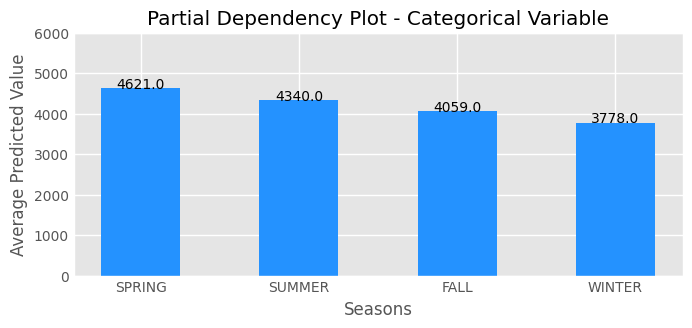

In [48]:
# method 1 - based on definition

# for regression prediction and categorical feature - Season 
# s1. we have replaced the categorical values one by one in the feature
# s2. since we have four unique values in the feature, accordingly we have four X feature input matrix
# s3. using the four input matrix to predict and averaged them. 

pdp_feature = 'season_encoded'
pdp_feature_value = [1,2,3,4]
pdp_predicted = []

# calculate average 
for v in pdp_feature_value:
    temp_df = outcome_df.copy()
    temp_df.loc[:, pdp_feature] = v
    pdp_predicted.append(
        np.mean(bike_model.predict(temp_df[feature_cols].to_numpy()))
        )
# get pdp result
pdp_outcome = np.hstack([np.array(pdp_feature_value).reshape(-1,1)\
    , np.round(np.array(pdp_predicted).reshape(-1,1),0)])

# plot the result
f,ax = plt.subplots(figsize=(7,3))
ax.bar(x=list(pdp_outcome[:,0]), height=list(pdp_outcome[:,1]), width = 0.5, align='center', tick_label=encode_map.get('season'), color = colour_collection.get('blue'))
ax.set_title("Partial Dependency Plot - Categorical Variable")
ax.set_xlabel("Seasons")
ax.set_ylabel("Average Predicted Value")
# adding labels to the chart
for i in pdp_feature_value:
    ax.text(i, pdp_outcome[i-1,1], pdp_outcome[i-1,1],horizontalalignment='center')
ax.set_ylim(0,6000)
plt.show()


In [ ]:
# for regression prediction and numerical feature
pdp_feature = 'temp'
